# First preliminary analysis of the same plate cell painting data


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import umap
import fastcluster  
from sklearn.preprocessing import StandardScaler
import polars as pl

In [ ]:
## download and concatenate the raw data from the two plates


plate1 = pd.read_csv("/Users/grigoryanmariam/newproject/2025_Grigoryan_Proteomics/00.exploratory_analysis/CP_data/BR00145692_augmented.csv")


plate2 = pd.read_csv("/Users/grigoryanmariam/newproject/2025_Grigoryan_Proteomics/00.exploratory_analysis/CP_data/BR00145695_augmented.csv")


df_combined = pd.concat([plate1, plate2], ignore_index=True)

df_combined.to_parquet("/Users/grigoryanmariam/newproject/2025_Grigoryan_Proteomics/00.exploratory_analysis/CP_data/raw.parquet", index=False)


In [ ]:
## load the raw data
raw_data = pl.read_parquet("/Users/grigoryanmariam/newproject/2025_Grigoryan_Proteomics/00.exploratory_analysis/CP_data/raw.parquet")
raw_data = raw_data.to_pandas()

In [ ]:
raw_data

,Metadata_plate_map_name,Metadata_source_plate,Metadata_source_well_position,Metadata_destination_plate,Metadata_BROAD_ID,Metadata_assay_conc_uM,Metadata_Source,Metadata_Vendor Catalog ID,Metadata_Compound Name,Metadata_Annotation,...,Nuclei_Texture_Variance_RNA_10_02_256,Nuclei_Texture_Variance_RNA_10_03_256,Nuclei_Texture_Variance_RNA_3_00_256,Nuclei_Texture_Variance_RNA_3_01_256,Nuclei_Texture_Variance_RNA_3_02_256,Nuclei_Texture_Variance_RNA_3_03_256,Nuclei_Texture_Variance_RNA_5_00_256,Nuclei_Texture_Variance_RNA_5_01_256,Nuclei_Texture_Variance_RNA_5_02_256,Nuclei_Texture_Variance_RNA_5_03_256
0,BR00145692,Plate1,A01,Dest1,BRD-K21728777-001-03-9,5.1,MedChemExpress,HY-13253,AMG 900,JUMP control,...,80.543,85.097,80.038,78.890,79.850,79.036,78.935,78.973,78.601,79.159
1,BR00145692,Plate1,A02,Dest1,DMSO,0.0,None,None,None,None,...,108.730,114.340,108.040,106.430,108.170,106.470,106.040,106.830,106.220,106.530
2,BR00145692,Plate1,A03,Dest1,EMPTY,0.0,None,None,None,None,...,105.030,111.800,104.750,103.040,104.920,103.590,102.810,103.310,102.850,103.570
3,BR00145692,Plate1,A04,Dest1,EMPTY,0.0,None,None,None,None,...,85.732,93.604,85.008,83.567,85.025,83.764,83.525,83.907,83.272,83.865
4,BR00145692,Plate1,A05,Dest1,EMPTY,0.0,None,None,None,None,...,79.294,85.062,78.536,77.294,78.764,77.527,77.016,77.334,77.237,77.795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,BR00145695,Plate1,P20,Dest1,EMPTY,0.0,None,None,None,None,...,110.300,115.300,109.350,108.010,109.250,108.060,107.870,108.460,107.800,108.480
764,BR00145695,Plate1,P21,Dest1,EMPTY,0.0,None,None,None,None,...,95.015,101.910,93.770,92.734,93.782,92.855,92.694,93.230,92.578,93.573
765,BR00145695,Plate1,P22,Dest1,EMPTY,0.0,None,None,None,None,...,85.765,92.267,85.033,83.814,84.742,83.671,83.739,84.084,83.515,84.374
766,BR00145695,Plate1,P23,Dest1,BRD-K91188791-001-18-3,5.1,Selleck,S7393,Aloxistatin,JUMP control,...,81.997,87.902,81.890,80.735,81.770,80.737,80.436,80.632,80.431,81.007


/var/folders/s6/prvmffjx7bl2mwcbcpxy05ph0000gn/T/ipykernel_1744/1040567733.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Replicate'] = filtered_data['Metadata_Plate'].apply(lambda x: 1 if x == 'BR00145692' else 2)


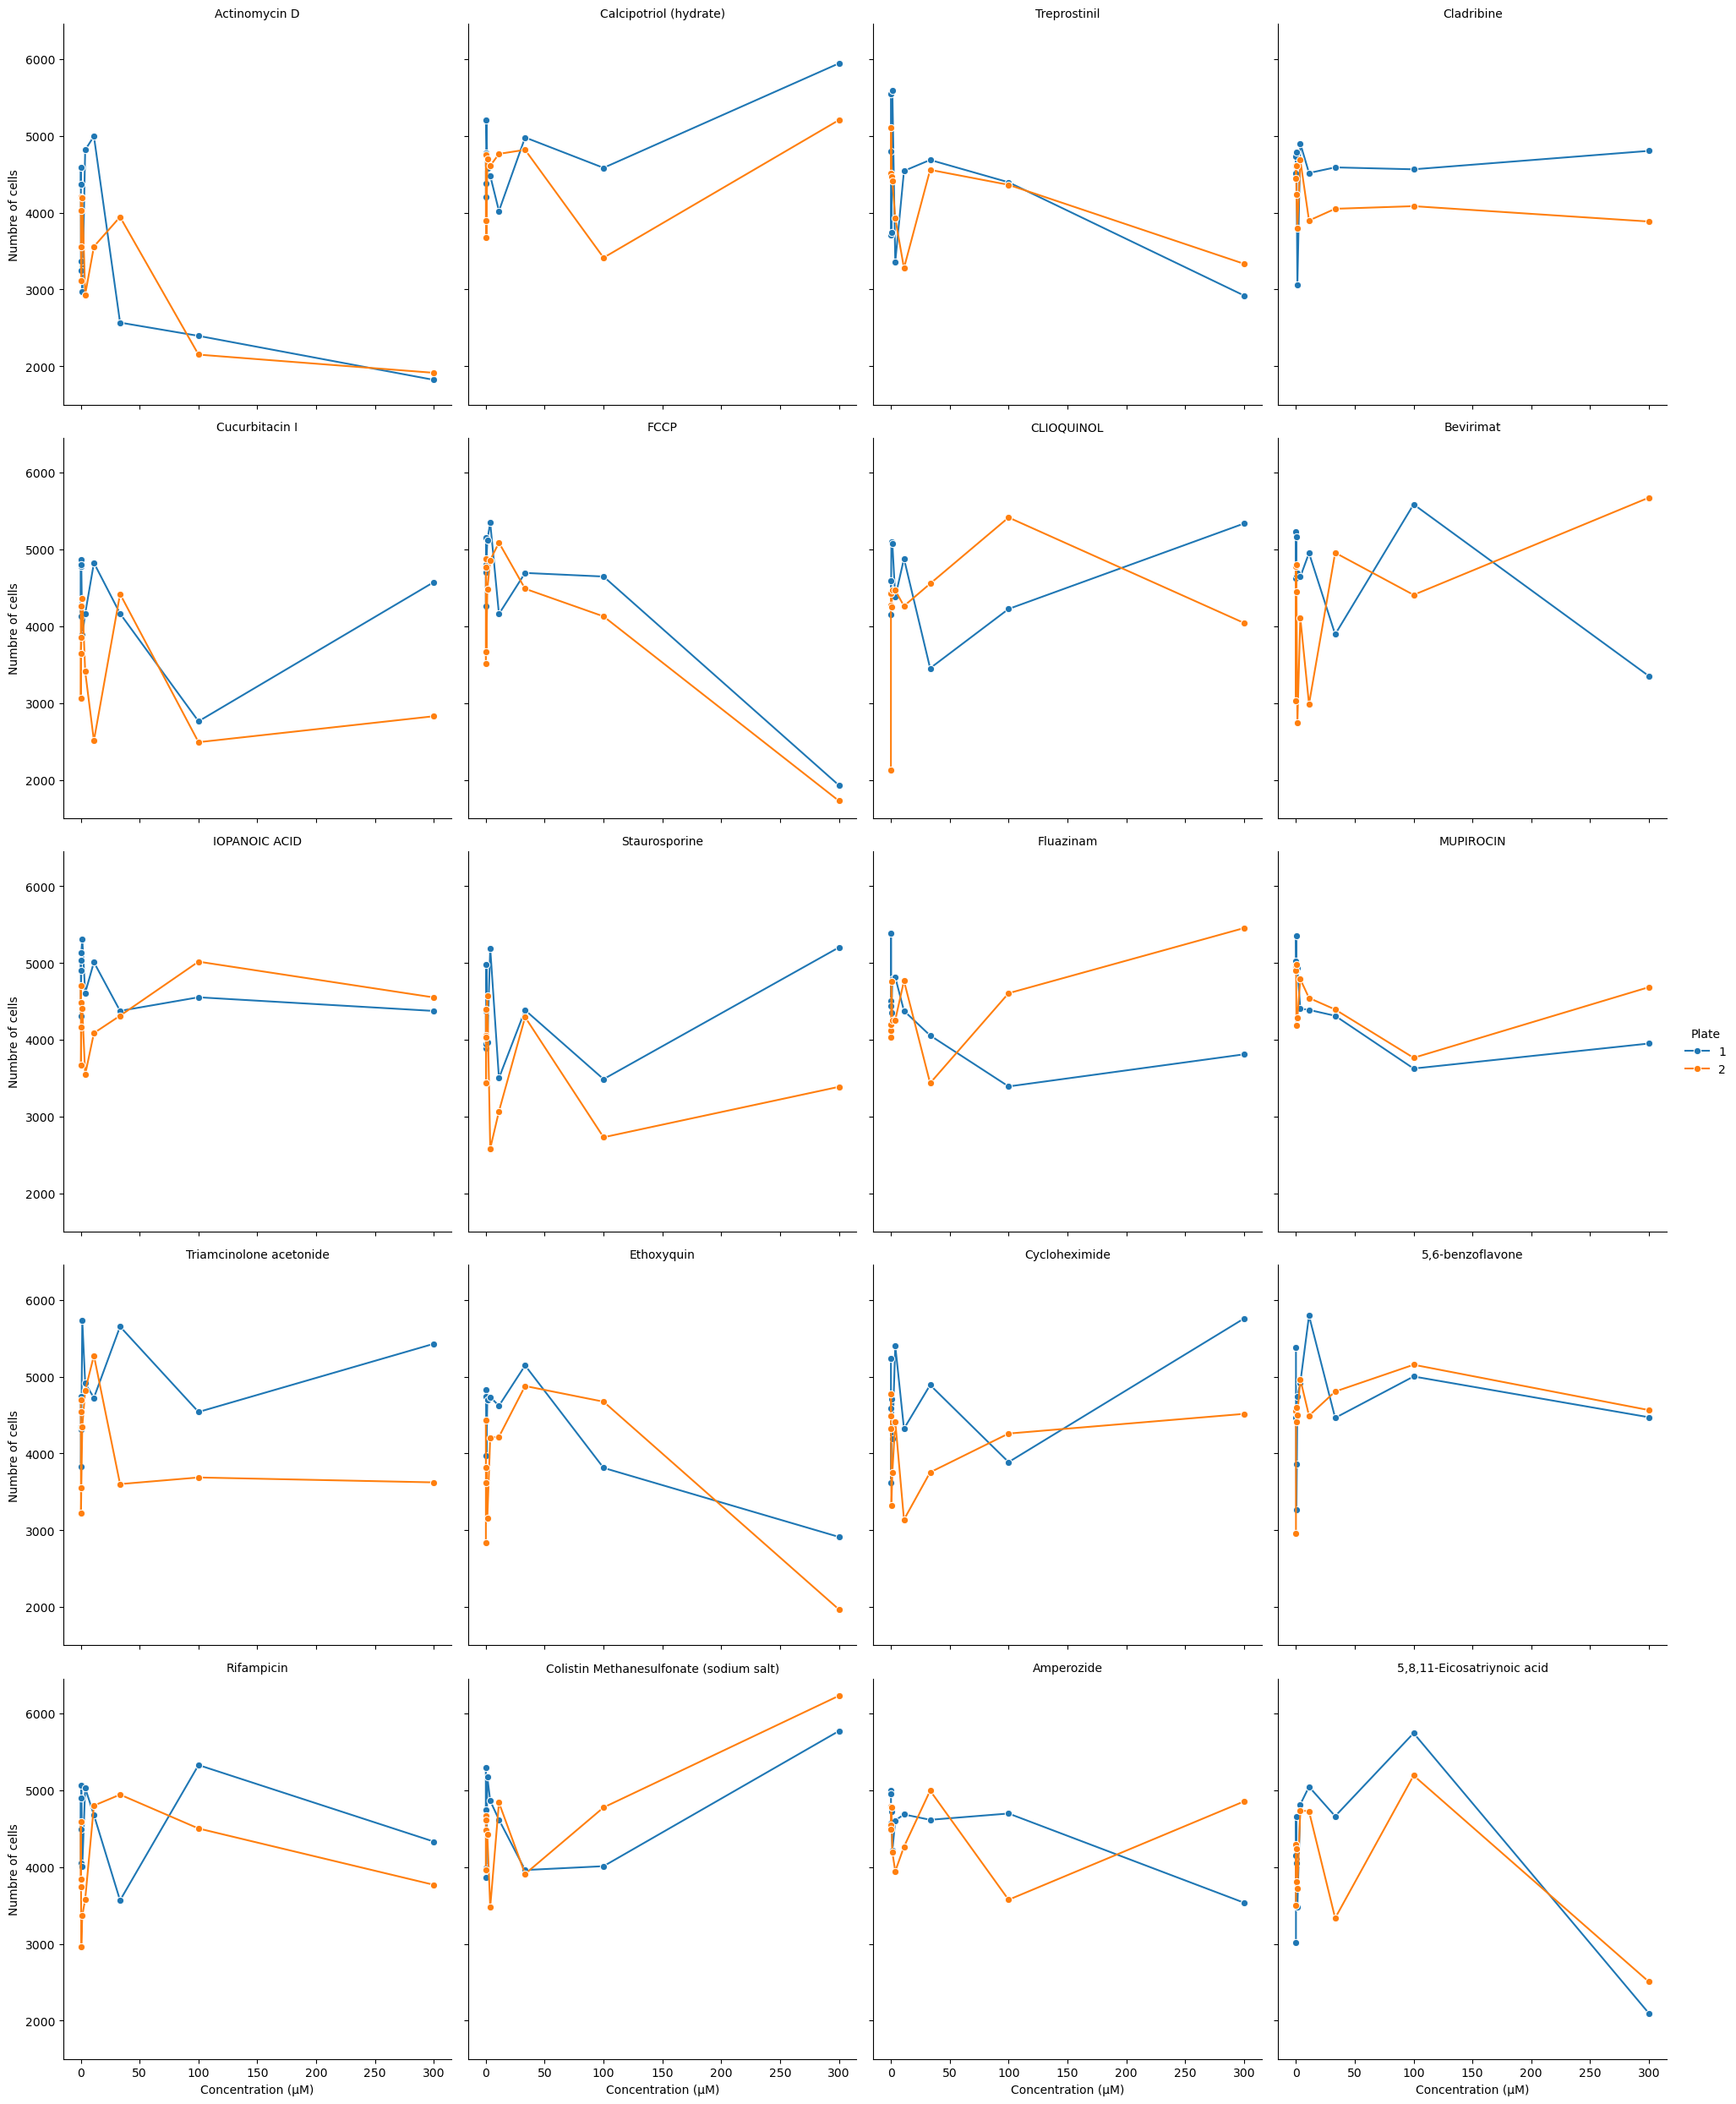

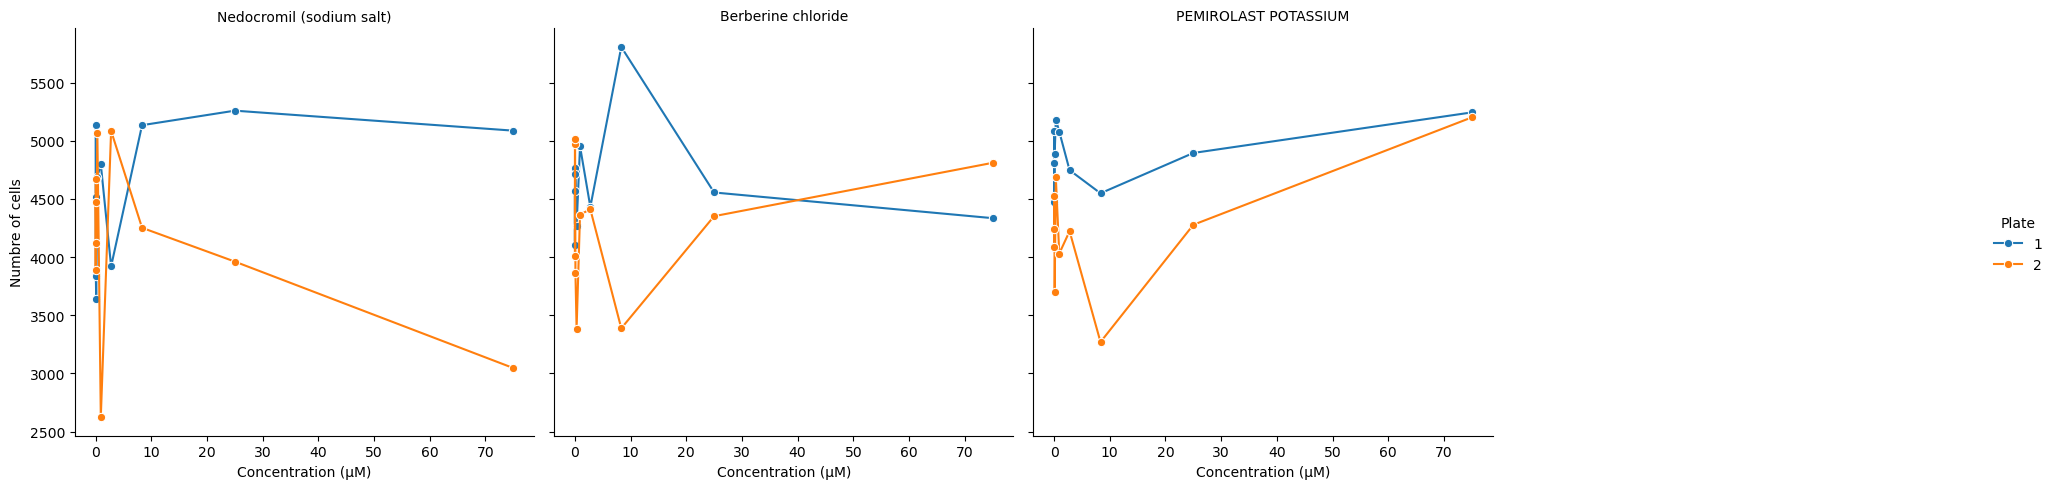

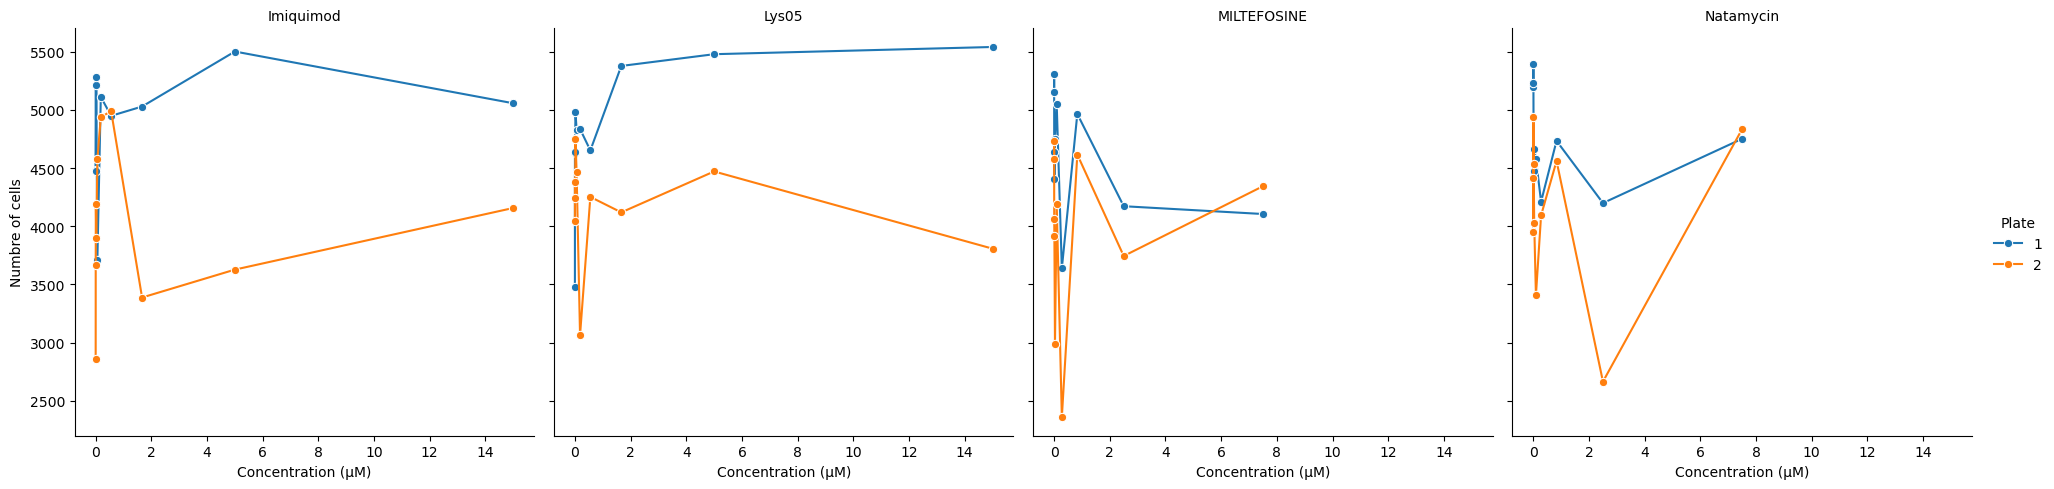

In [ ]:
## cell count plots of compound that have multiple concentrations

compounds_with_multiple_concentrations = raw_data.groupby('Metadata_Compound Name')['Metadata_assay_conc_uM'].nunique()
compounds_with_multiple_concentrations = compounds_with_multiple_concentrations[compounds_with_multiple_concentrations > 1].index


filtered_data = raw_data[raw_data['Metadata_Compound Name'].isin(compounds_with_multiple_concentrations)]

filtered_data['Replicate'] = filtered_data['Metadata_Plate'].apply(lambda x: 1 if x == 'BR00145692' else 2)


max_concentration = filtered_data.groupby('Metadata_Compound Name')['Metadata_assay_conc_uM'].max()

compounds_max_300 = max_concentration[max_concentration == 300].index
compounds_max_100 = max_concentration[(max_concentration >= 40) & (max_concentration <= 100)].index

compounds_max_50 = max_concentration[max_concentration <= 30].index

filtered_data_max_300 = filtered_data[filtered_data['Metadata_Compound Name'].isin(compounds_max_300)]
filtered_data_max_100 = filtered_data[filtered_data['Metadata_Compound Name'].isin(compounds_max_100)]
filtered_data_max_50 = filtered_data[filtered_data['Metadata_Compound Name'].isin(compounds_max_50)]


g_300 = sns.FacetGrid(filtered_data_max_300, col="Metadata_Compound Name", hue="Replicate", col_wrap=4, height=5)
g_300.map(sns.lineplot, "Metadata_assay_conc_uM", "Metadata_Count_Cells", marker="o")
g_300.set_axis_labels("Concentration (µM)", "Numbre of cells")
g_300.set_titles("{col_name}")
g_300.add_legend(title="Plate")
plt.show()

g_100 = sns.FacetGrid(filtered_data_max_100, col="Metadata_Compound Name", hue="Replicate", col_wrap=4, height=5)
g_100.map(sns.lineplot, "Metadata_assay_conc_uM", "Metadata_Count_Cells", marker="o")
g_100.set_axis_labels("Concentration (µM)", "Numbre of cells")
g_100.set_titles("{col_name}")
g_100.add_legend(title="Plate")
plt.show()

g_50 = sns.FacetGrid(filtered_data_max_50, col="Metadata_Compound Name", hue="Replicate", col_wrap=4, height=5)
g_50.map(sns.lineplot, "Metadata_assay_conc_uM", "Metadata_Count_Cells", marker="o")
g_50.set_axis_labels("Concentration (µM)", "Numbre of cells")
g_50.set_titles("{col_name}")
g_50.add_legend(title="Plate")
plt.show()


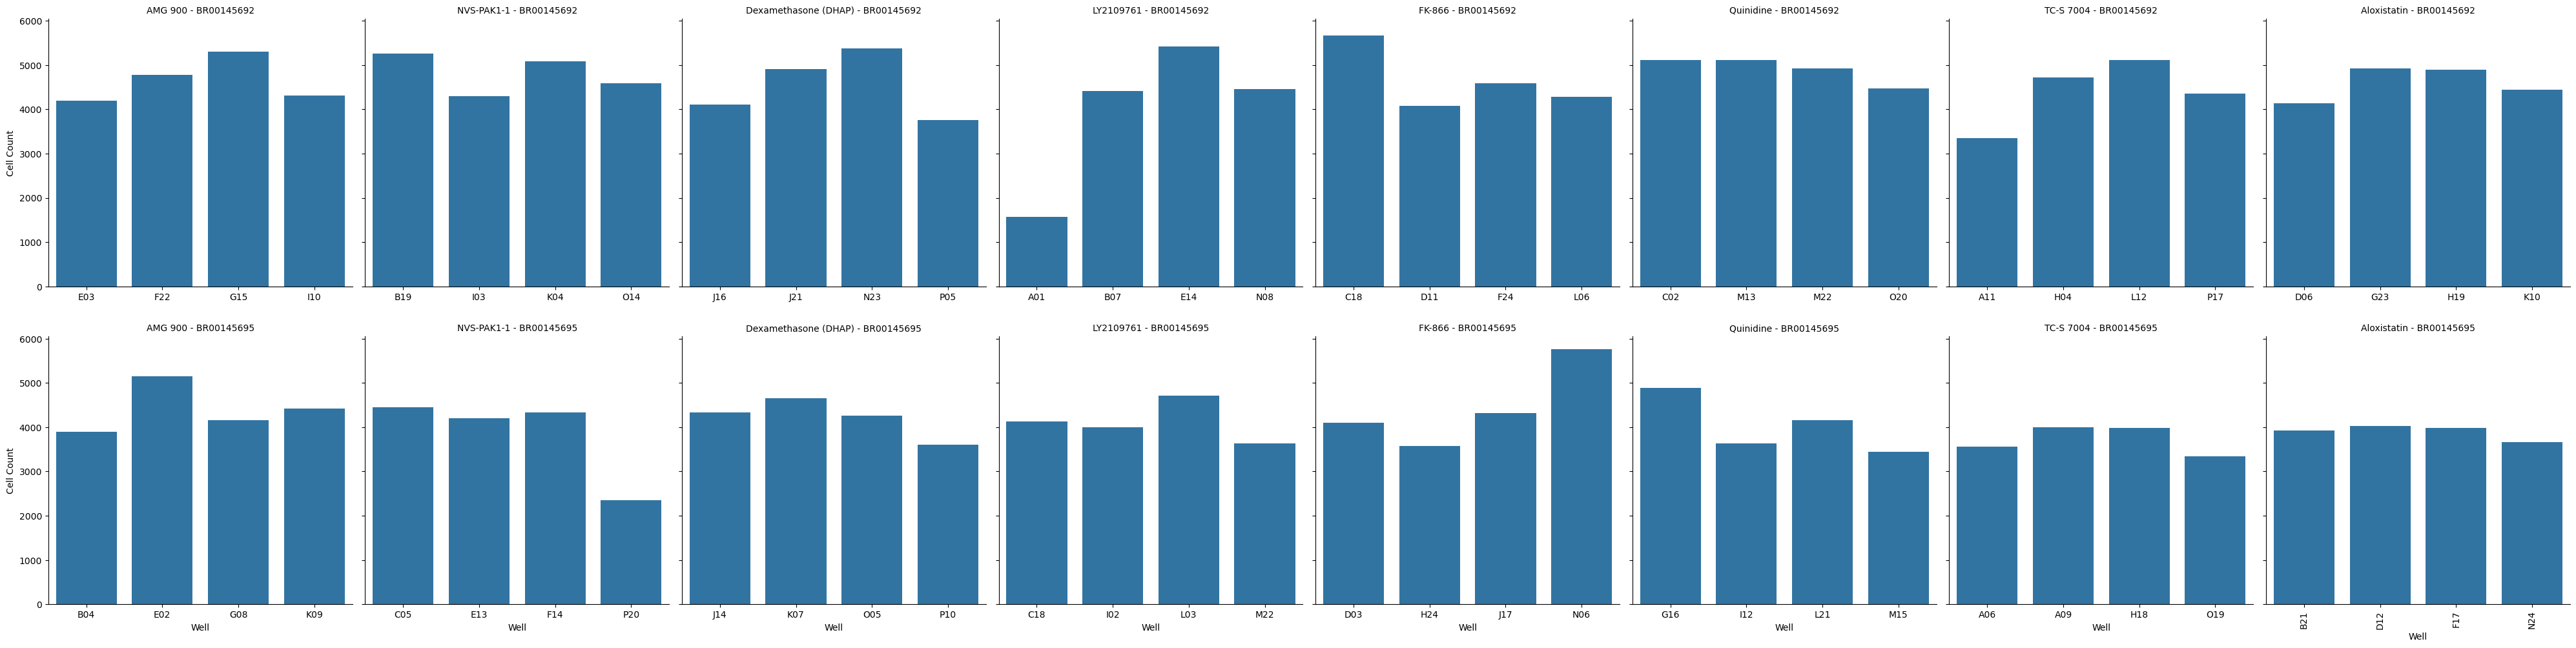

In [ ]:
## cell count plots of compound that have only one concentration

compound_counts = raw_data.groupby('Metadata_Compound Name')['Metadata_assay_conc_uM'].nunique()
single_concentration_compounds = compound_counts[compound_counts == 1].index
filtered_data_single_concentration = raw_data[raw_data['Metadata_Compound Name'].isin(single_concentration_compounds)]


g_single_concentration = sns.FacetGrid(
    filtered_data_single_concentration, 
    col="Metadata_Compound Name", 
    row="Metadata_Plate", 
    height=5, 
    sharex=False, 
    sharey=True  
)

def plot_bar(data, **kwargs):
    compound = data["Metadata_Compound Name"].iloc[0]  
    plate = data["Metadata_Plate"].iloc[0]  
    wells = sorted(data["Metadata_Well"].unique())  
    sns.barplot(x="Metadata_Well", y="Metadata_Count_Cells", data=data, order=wells, **kwargs)


g_single_concentration.map_dataframe(plot_bar)


g_single_concentration.set_axis_labels("Well", "Cell Count")
g_single_concentration.set_titles("{col_name} - {row_name}")

plt.xticks(rotation=90) 
plt.show()


## Normalized data

In [ ]:
## dowload and concatenate the normalized data

plate1 = pd.read_csv("/Users/grigoryanmariam/newproject/2025_Grigoryan_Proteomics/00.exploratory_analysis/CP_data/BR00145692_normalized_feature_select_batch.csv")


plate2 = pd.read_csv("/Users/grigoryanmariam/newproject/2025_Grigoryan_Proteomics/00.exploratory_analysis/CP_data/BR00145695_normalized_feature_select_batch.csv")


df_combined = pd.concat([plate1, plate2], ignore_index=True)

df_combined.to_parquet("/Users/grigoryanmariam/newproject/2025_Grigoryan_Proteomics/00.exploratory_analysis/CP_data/normalized.parquet", index=False)


In [ ]:
## load the normalized data

norm_data = pl.read_parquet("../CP_data/normalized.parquet")
norm_data = norm_data.to_pandas()


In [ ]:
norm_data

,Metadata_plate_map_name,Metadata_source_plate,Metadata_source_well_position,Metadata_destination_plate,Metadata_BROAD_ID,Metadata_assay_conc_uM,Metadata_Source,Metadata_Vendor Catalog ID,Metadata_Compound Name,Metadata_Annotation,...,Nuclei_Texture_InfoMeas1_RNA_5_01_256,Nuclei_Texture_InfoMeas2_AGP_10_03_256,Nuclei_Texture_InfoMeas2_AGP_3_00_256,Nuclei_Texture_InfoMeas2_ER_10_01_256,Nuclei_Texture_InfoMeas2_Mito_10_01_256,Nuclei_Texture_InfoMeas2_RNA_10_03_256,Nuclei_Texture_InverseDifferenceMoment_AGP_10_01_256,Nuclei_Texture_InverseDifferenceMoment_RNA_3_02_256,Nuclei_Texture_SumEntropy_Brightfield_10_01_256,Nuclei_Texture_SumVariance_Brightfield_3_00_256
0,BR00145692,Plate1,A01,Dest1,BRD-K21728777-001-03-9,5.1,MedChemExpress,HY-13253,AMG 900,JUMP control,...,1.194400,-0.121240,-0.19153,-0.23647,0.12668,-0.91800,0.19934,1.484700,-0.50978,-0.69957
1,BR00145692,Plate1,A02,Dest1,DMSO,0.0,None,None,None,None,...,-0.149960,-0.460830,-0.79834,0.65734,-0.63646,0.42925,1.63270,-0.845560,0.72777,0.89360
2,BR00145692,Plate1,A03,Dest1,EMPTY,0.0,None,None,None,None,...,-0.984230,1.395700,1.86650,1.52600,-0.70516,1.40270,-0.18847,-0.483290,0.51955,-0.50481
3,BR00145692,Plate1,A04,Dest1,EMPTY,0.0,None,None,None,None,...,-0.009823,1.135000,1.34350,0.90851,0.35059,1.02260,0.18429,0.100360,1.96040,2.36100
4,BR00145692,Plate1,A05,Dest1,EMPTY,0.0,None,None,None,None,...,0.077927,1.183300,1.34710,0.86869,0.81988,0.57657,-0.40327,0.767230,1.19310,0.64904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,BR00145695,Plate1,P20,Dest1,EMPTY,0.0,None,None,None,None,...,-1.068300,0.007106,-0.65811,0.85020,-1.17360,2.09140,1.03960,-2.382100,1.02390,0.16092
764,BR00145695,Plate1,P21,Dest1,EMPTY,0.0,None,None,None,None,...,-0.032581,0.332840,-0.11592,0.49541,-0.40905,1.31860,0.36701,-1.113600,1.75430,1.20500
765,BR00145695,Plate1,P22,Dest1,EMPTY,0.0,None,None,None,None,...,-0.281320,-0.134440,0.15734,0.74835,0.26980,0.96671,0.61150,-0.055743,0.88111,0.29698
766,BR00145695,Plate1,P23,Dest1,BRD-K91188791-001-18-3,5.1,Selleck,S7393,Aloxistatin,JUMP control,...,1.125900,-3.044400,-2.09120,-0.60333,-3.44900,-0.32362,2.60590,-0.719090,-1.31020,-0.76559


In [ ]:
## deleting the rows that are empty from 'Metadata_BROAD_ID' (untreated ones) and replacing the empty values of Compound Name and Annotation with DMSO

norm_data = norm_data[norm_data['Metadata_BROAD_ID'] != 'EMPTY']
norm_data.loc[norm_data['Metadata_BROAD_ID'] == 'DMSO', 'Metadata_Compound Name'] = 'DMSO'
norm_data.loc[norm_data['Metadata_BROAD_ID'] == 'DMSO', 'Metadata_Annotation'] = 'DMSO'

In [ ]:
## we drop the metadata columns to keep only the CP features (here 688 x 720)

norm_signal_filtered = norm_data.drop(columns=[col for col in norm_data.columns if col.startswith("Metadata")])
norm_signal_filtered

,Image_Granularity_10_AGP,Image_Granularity_10_Brightfield,Image_Granularity_10_DNA,Image_Granularity_10_ER,Image_Granularity_10_Mito,Image_Granularity_10_RNA,Image_Granularity_11_AGP,Image_Granularity_11_Brightfield,Image_Granularity_11_DNA,Image_Granularity_11_ER,...,Nuclei_Texture_InfoMeas1_RNA_5_01_256,Nuclei_Texture_InfoMeas2_AGP_10_03_256,Nuclei_Texture_InfoMeas2_AGP_3_00_256,Nuclei_Texture_InfoMeas2_ER_10_01_256,Nuclei_Texture_InfoMeas2_Mito_10_01_256,Nuclei_Texture_InfoMeas2_RNA_10_03_256,Nuclei_Texture_InverseDifferenceMoment_AGP_10_01_256,Nuclei_Texture_InverseDifferenceMoment_RNA_3_02_256,Nuclei_Texture_SumEntropy_Brightfield_10_01_256,Nuclei_Texture_SumVariance_Brightfield_3_00_256
0,0.80948,-1.030700,1.241400,-0.35150,1.45370,-0.066972,1.095900,2.356000,1.364700,0.73804,...,1.19440,-0.12124,-0.19153,-0.236470,0.12668,-0.91800,0.19934,1.48470,-0.50978,-0.699570
1,1.66220,-0.387660,1.035300,1.71140,2.53330,1.953500,2.301600,-0.011252,1.295100,1.62840,...,-0.14996,-0.46083,-0.79834,0.657340,-0.63646,0.42925,1.63270,-0.84556,0.72777,0.893600
22,-1.22680,1.430600,-0.026652,-1.58760,-0.83668,-1.138500,-0.667280,-0.169380,-0.157120,-1.37550,...,0.24426,-1.65760,-0.78913,-2.097000,-0.85117,-1.91860,-0.19934,0.62690,-1.78540,0.682970
23,0.18614,0.372460,0.057158,0.67376,1.30960,-0.096940,1.413000,0.091134,-0.000804,-0.71518,...,-0.10150,-0.79855,-1.10870,1.068400,-0.22790,1.32240,2.43260,-1.44230,1.32310,0.664900
24,-1.23310,1.452200,-0.262030,-1.09070,-0.19866,-0.333500,-0.723670,0.748970,-0.393800,-0.33220,...,1.43610,0.92825,-0.25875,0.948330,1.09650,-0.16118,-0.28877,1.34270,0.23607,-0.639080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
743,0.35287,-0.747670,0.873510,1.51470,2.18130,2.215600,0.304160,-0.541650,0.144780,2.31790,...,-0.27569,-0.76999,-0.21360,0.052273,-0.85377,0.10971,0.38729,-1.03190,-0.16036,0.015333
744,2.16010,-0.202530,0.949210,1.72590,1.04790,0.772960,3.231000,-1.289200,0.761060,1.39620,...,-0.95300,-0.09124,0.23647,0.560160,0.24847,0.93014,0.25117,-1.10500,0.60356,0.194260
745,0.83054,-0.063717,0.876650,0.36962,0.64960,-0.586350,-0.675590,1.097500,1.464200,0.42769,...,-0.77693,1.36180,0.97155,0.951370,0.96779,1.16610,-0.77432,-0.50107,1.06090,0.645610
766,-0.39137,0.262640,0.750020,0.17772,0.34942,-0.670040,0.033633,0.322640,0.033875,-0.21648,...,1.12590,-3.04440,-2.09120,-0.603330,-3.44900,-0.32362,2.60590,-0.71909,-1.31020,-0.765590


In [ ]:
# replace missing values with the mean of the column
norm_signal_filtered.fillna(norm_signal_filtered.mean(), inplace=True)


missing_values = norm_signal_filtered.isnull().sum().sum()
print(f"Total missing values after imputation: {missing_values}")

print(f"Shape of the data after imputation: {norm_signal_filtered.shape}")


Total missing values after imputation: 0
Shape of the data after imputation: (688, 720)


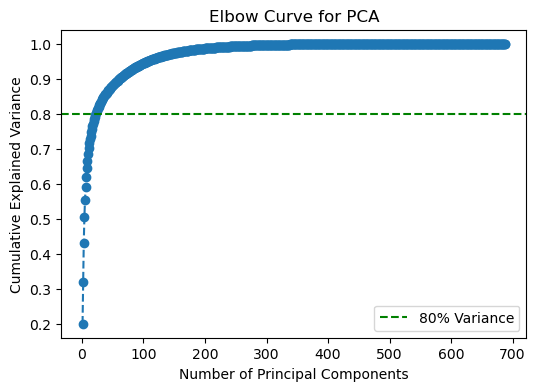

Number of components to explain 80% of variance: 23


In [ ]:
# PCA analysis to determine the number of components to explain 99% of variance

scaler = StandardScaler()
scaled = scaler.fit_transform(norm_signal_filtered)

pca = PCA()
pca.fit(scaled)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)
n_components= np.argmax(cumulative_variance >= 0.8) +1



plt.figure(figsize=(6, 4))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance, marker='o', linestyle='--')
plt.axhline(y=0.8, color='g', linestyle='--', label="80% Variance")
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Elbow Curve for PCA')
plt.legend()
plt.show()

print(f"Number of components to explain 80% of variance: {n_components}")

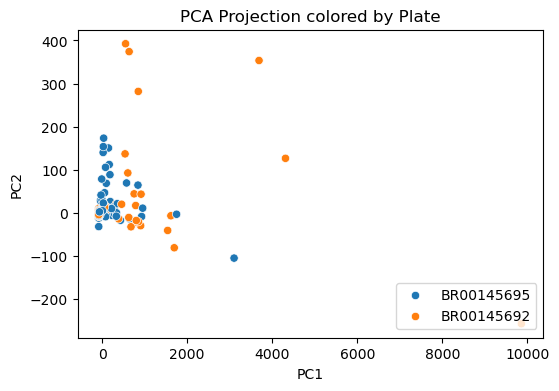

In [ ]:
## non scaled data PCA

pca = PCA(n_components)
principal_components = pca.fit_transform(norm_signal_filtered)

column_names = [f'PC{i+1}' for i in range(n_components)]
pca_df = pd.DataFrame(data=principal_components, columns=column_names)
pca_df.index = norm_signal_filtered.index 

pca_df['Plate'] = norm_data.loc[norm_signal_filtered.index, 'Metadata_Plate']
pca_df['Compound'] = norm_data.loc[norm_signal_filtered.index, 'Metadata_Compound Name']
pca_df['Concentration'] = norm_data.loc[norm_signal_filtered.index, 'Metadata_assay_conc_uM']
pca_df= pca_df.sample(frac=1).reset_index(drop=True)

plt.figure(figsize=(6, 4))
sns.scatterplot(x=pca_df['PC1'], y=pca_df['PC2'], hue=pca_df['Plate'], palette="tab10")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Projection colored by Plate")
plt.legend(bbox_to_anchor=(0.67, 0.2), loc='upper left')
plt.show()

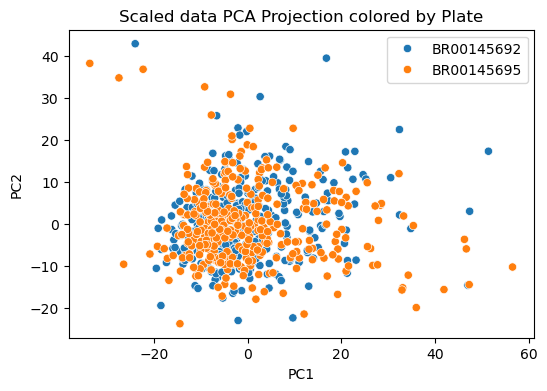

In [ ]:
## scaled data PCA

scaler = StandardScaler()
scaled = scaler.fit_transform(norm_signal_filtered)

pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(scaled)


column_names = [f'PC{i+1}' for i in range(n_components)]
pca_df = pd.DataFrame(data=principal_components, columns=column_names, index=norm_signal_filtered.index)


pca_df['Plate'] = norm_data.loc[norm_signal_filtered.index, 'Metadata_Plate']
pca_df['Compound'] = norm_data.loc[norm_signal_filtered.index, 'Metadata_Compound Name']
pca_df['Concentration'] = norm_data.loc[norm_signal_filtered.index, 'Metadata_assay_conc_uM']

plt.figure(figsize=(6, 4))
sns.scatterplot(x=pca_df['PC1'], y=pca_df['PC2'], hue=pca_df['Plate'], palette="tab10")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Scaled data PCA Projection colored by Plate")
plt.legend(bbox_to_anchor=(0.67, 1), loc='upper left')
plt.show()

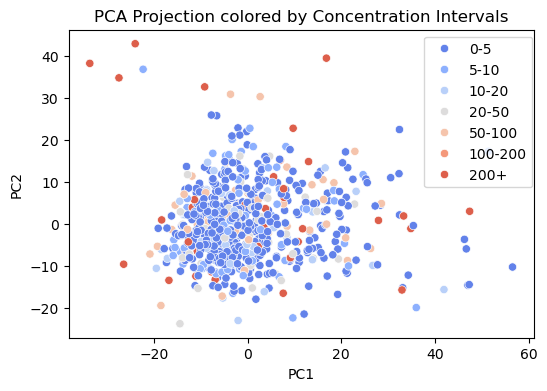

In [ ]:
##scaled data PCA colored by concentration intervals

bins = [0, 5, 10, 20, 50, 100, 200, 300] 
labels = ['0-5', '5-10', '10-20', '20-50', '50-100', '100-200', '200+']  


pca_df['Concentration_Binned'] = pd.cut(pca_df['Concentration'], bins=bins, labels=labels, include_lowest=True)

plt.figure(figsize=(6, 4))
sns.scatterplot(x=pca_df['PC1'], y=pca_df['PC2'], hue=pca_df['Concentration_Binned'], palette="coolwarm")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Projection colored by Concentration Intervals")
plt.legend(bbox_to_anchor=(0.75, 1), loc='upper left')
plt.show()

['Compound' 'DMSO']


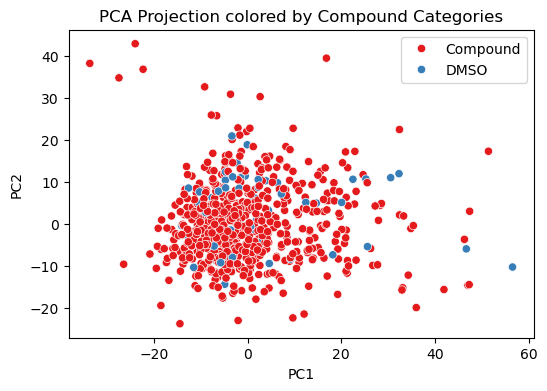

In [ ]:
# scaled data PCA by compound categories

pca_df['Category'] = pca_df['Compound'].apply(
    lambda x: 'DMSO' if x == 'DMSO' else ('Compound')
)


print(pca_df['Category'].unique())

plt.figure(figsize=(6, 4))
sns.scatterplot(x=pca_df['PC1'], y=pca_df['PC2'], hue=pca_df['Category'], palette="Set1")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Projection colored by Compound Categories")
plt.legend(bbox_to_anchor=(0.7, 1), loc='upper left')
plt.show()



0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
/var/folders/s6/prvmffjx7bl2mwcbcpxy05ph0000gn/T/ipykernel_1744/2658235168.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  norm_data["UMAP1"], norm_data["UMAP2"] = umap_result[:, 0], umap_result[:, 1]
/var/folders/s6/prvmffjx7bl2mwcbcpxy05ph0000gn/T/ipykernel_1744/2658235168.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

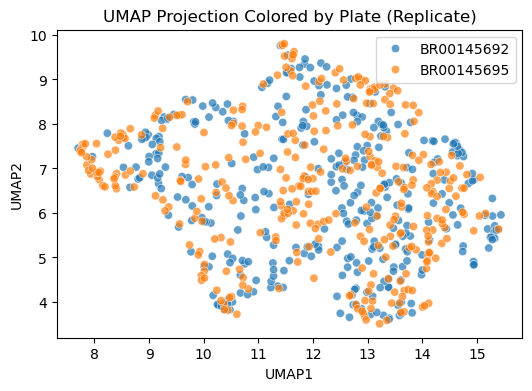

In [ ]:
# UMAP projection of the scaled data

umap_model = umap.UMAP(n_components=2)
umap_result = umap_model.fit_transform(scaled)

norm_data["UMAP1"], norm_data["UMAP2"] = umap_result[:, 0], umap_result[:, 1]


metadata_color =  "Metadata_Plate"  #"Metadata_compound_concentration"  


plt.figure(figsize=(6, 4))
sns.scatterplot(
    x="UMAP1", y="UMAP2", hue=norm_data[metadata_color],    #style=norm_data["Metadata_BROAD_ID"],
    palette="tab10", data=norm_data, alpha=0.7 )
plt.title("UMAP Projection Colored by Plate (Replicate)")
plt.legend(bbox_to_anchor=(0.67, 1), loc='upper left')
plt.show()

### Scatterplots of replicates

In [ ]:
## the list of compound with unique concentration values + DMSO with 0uM concentration

single_concentration_compounds = norm_data.groupby('Metadata_Compound Name')['Metadata_assay_conc_uM'].nunique()
compounds_with_single_concentration = single_concentration_compounds[single_concentration_compounds == 1].index
filtered_data = norm_data[norm_data['Metadata_Compound Name'].isin(compounds_with_single_concentration)]

print(compounds_with_single_concentration)

Index(['AMG 900', 'Aloxistatin', 'DMSO', 'Dexamethasone (DHAP)', 'FK-866',
       'LY2109761', 'NVS-PAK1-1', 'Quinidine', 'TC-S 7004'],
      dtype='object', name='Metadata_Compound Name')


In [ ]:
## first 5 principal components tables, score per plate/replicate

num_pcs = 5  
pc_columns= [f"PC{i+1}" for i in range(num_pcs)]  


pca_pl = pl.DataFrame(pca_df)
pca_pl = pca_pl.filter(~pl.col("Compound").is_in(list(compounds_with_single_concentration)))

pca_melt = pca_pl.melt(
    id_vars=["Compound", "Concentration", "Plate"],
    value_vars=pc_columns,
    variable_name="PC",
    value_name="Score"
)

pc_tables = {}

for pc in pc_columns:
    globals()[pc.lower()] = pca_melt.filter(pl.col("PC") == pc).pivot(
        on="Plate",
        index=["Compound", "Concentration"],
        values="Score"
    ).to_pandas()

print(pc1.head())

        Compound  Concentration  BR00145692  BR00145695
0  Actinomycin D       300.0000   47.353026   33.284305
1  Actinomycin D       100.0000   22.883957   13.735376
2  Actinomycin D        33.3330   16.278714   -9.293294
3  Actinomycin D        11.1110  -19.443028    0.821910
4  Actinomycin D         3.7037  -15.904853   -1.204060


/var/folders/s6/prvmffjx7bl2mwcbcpxy05ph0000gn/T/ipykernel_1744/2970861907.py:10: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  pca_melt = pca_pl.melt(


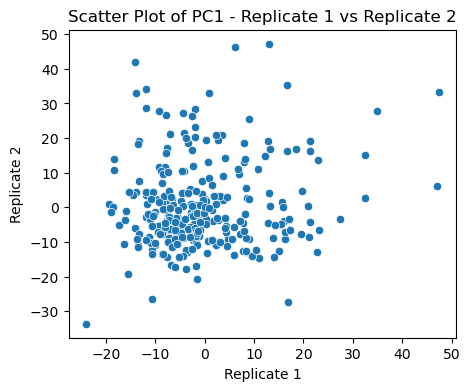

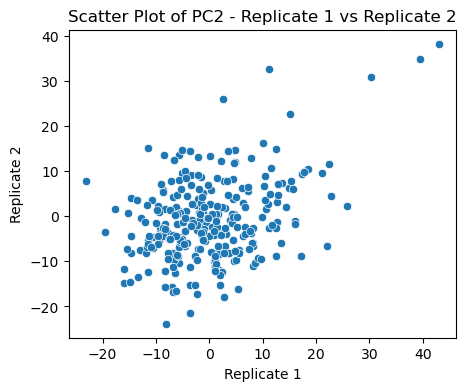

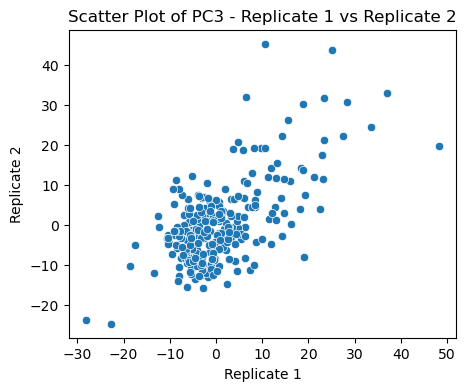

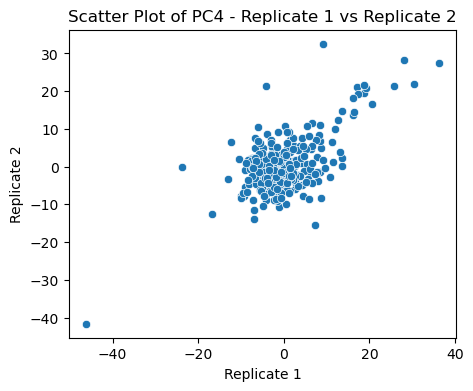

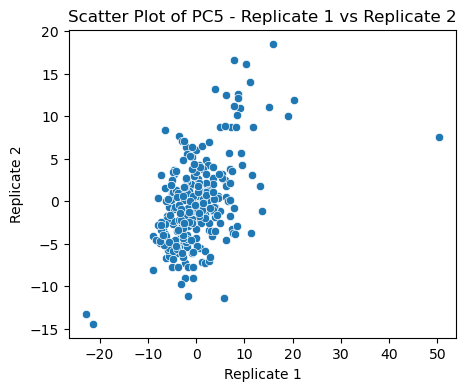

In [ ]:
def plot_scatter_plots(pc_df, pc_name):

    for plate1, plate2 in [('BR00145692', 'BR00145695')]: 
        if plate1 in pc_df.columns and plate2 in pc_df.columns:
            plt.figure(figsize=(5, 4))
            sns.scatterplot(x=pc_df[plate1], y=pc_df[plate2]) #, hue=pc_df['Concentration'], palette="tab10")
            plt.title(f"Scatter Plot of {pc_name} - Replicate 1 vs Replicate 2")
            plt.xlabel("Replicate 1")
            plt.ylabel("Replicate 2")
            #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.show()

pc_dataframes = [pc1, pc2, pc3, pc4, pc5]

for i, pc_df in enumerate(pc_dataframes, start=1):
    plot_scatter_plots(pc_df, f"PC{i}")


## plot the distribution of the features

df= norm_signal_filtered.copy()
batch_size = 20  
num_batches = len(df.columns) // batch_size + 1  

for batch in range(num_batches):
    features = df.columns[batch * batch_size : (batch + 1) * batch_size]
    
    plt.figure(figsize=(15, 10))
    
    for i, feature in enumerate(features, 1):
        plt.subplot(4, 5, i) 
        sns.kdeplot(df[feature], fill=True, color="teal", alpha=0.6)
        plt.title(feature, fontsize=8)
        plt.xticks([])
        plt.yticks([])
    
    plt.tight_layout()
    plt.show()

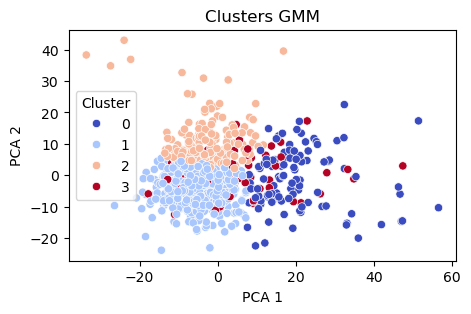

In [ ]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=4, random_state=42)
df["Cluster_GMM"] = gmm.fit_predict(scaled)


plt.figure(figsize=(5,3))
sns.scatterplot(x=pca_df.iloc[:, 0], y=pca_df.iloc[:, 1], hue=df["Cluster_GMM"], palette="coolwarm")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Clusters GMM")
plt.legend(title="Cluster")
plt.show()


## Supervised approach for POD determination

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, precision_recall_curve
from sklearn.model_selection import train_test_split

In [ ]:
norm_data = pl.read_parquet("../CP_data/normalized.parquet")
norm_data = norm_data.to_pandas()

norm_data = norm_data[norm_data['Metadata_BROAD_ID'] != 'EMPTY']
norm_data.loc[norm_data['Metadata_BROAD_ID'] == 'DMSO', 'Metadata_Compound Name'] = 'DMSO'
norm_data.loc[norm_data['Metadata_BROAD_ID'] == 'DMSO', 'Metadata_Annotation'] = 'DMSO'

We use a Random Forest classifier to distinguish treated cells from DMSO controls at various concentrations for each compound. By training the model at each concentration, we measure how well the treatment effect could be detected (via AUC) and identify the lowest concentration at which the compound begins to show a significant deviation from DMSO, serving as an estimate of the Point of Departure (POD).

In [ ]:

def manual_train_test_split(X, y):

    class_0_indices = np.where(y == 0)[0]
    class_1_indices = np.where(y == 1)[0]
    
    X_train = np.concatenate([X[class_0_indices[0:1]], X[class_1_indices[0:1]]])  
    X_test = np.concatenate([X[class_0_indices[1:]], X[class_1_indices[1:]]])
    
    y_train = np.concatenate([y[class_0_indices[0:1]], y[class_1_indices[0:1]]])
    y_test = np.concatenate([y[class_0_indices[1:]], y[class_1_indices[1:]]])
    
    return X_train, X_test, y_train, y_test



In [ ]:

compound_col = "Metadata_Compound Name"
concentration_col = "Metadata_assay_conc_uM"
features = norm_signal_filtered.columns
results = {}

pod_results = []

df_dmso = norm_data[norm_data[concentration_col] == 0].copy()
df_dmso_filt = df_dmso.drop(columns=[col for col in df_dmso.columns if col.startswith("Metadata")])

for compound in norm_data[compound_col].unique():
    df_compound = norm_data[norm_data[compound_col] == compound].copy()
    concentrations = sorted(df_compound[concentration_col].unique())
    concentrations = [c for c in concentrations if c != 0]
    aucs = []

    for c in concentrations:
        df_treated = df_compound[df_compound[concentration_col] == c].copy()

        df_treated_filt = df_treated.drop(columns=[col for col in df_treated.columns if col.startswith("Metadata")])

        df_subset = pd.concat([df_dmso, df_treated])

        df_subset_filt = pd.concat([df_dmso_filt, df_treated_filt])
        X = df_subset_filt[features].values

        y = (df_subset[concentration_col] != 0).astype(int).values

        X_train, X_test, y_train, y_test = manual_train_test_split(X, y)

        clf = RandomForestClassifier(n_estimators=100, random_state=42)
        clf.fit(X_train, y_train)
        y_pred = clf.predict_proba(X_test)[:, 1]

        auc = roc_auc_score(y_test, y_pred)
        aucs.append((c, auc))

        precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
        best_threshold = thresholds[np.argmax(precision + recall)]  

        print(f"Compound: {compound}, Concentration: {c} µM, AUC: {auc:.3f}, Optimal Threshold: {best_threshold:.3f}")

    results[compound] = aucs

# Display the results
for compound, auc_values in results.items():
    print(f"{compound}: {auc_values}")


Compound: AMG 900, Concentration: 5.1 µM, AUC: 0.748, Optimal Threshold: 0.520
Compound: Actinomycin D, Concentration: 0.0152 µM, AUC: 0.960, Optimal Threshold: 0.590
Compound: Actinomycin D, Concentration: 0.0457 µM, AUC: 1.000, Optimal Threshold: 0.670
Compound: Actinomycin D, Concentration: 0.13717 µM, AUC: 1.000, Optimal Threshold: 0.530
Compound: Actinomycin D, Concentration: 0.41152 µM, AUC: 0.952, Optimal Threshold: 0.550
Compound: Actinomycin D, Concentration: 1.2346 µM, AUC: 1.000, Optimal Threshold: 0.570
Compound: Actinomycin D, Concentration: 3.7037 µM, AUC: 1.000, Optimal Threshold: 0.620
Compound: Actinomycin D, Concentration: 11.111 µM, AUC: 0.421, Optimal Threshold: 0.490
Compound: Actinomycin D, Concentration: 33.333 µM, AUC: 0.849, Optimal Threshold: 0.540
Compound: Actinomycin D, Concentration: 100.0 µM, AUC: 1.000, Optimal Threshold: 0.550
Compound: Actinomycin D, Concentration: 300.0 µM, AUC: 1.000, Optimal Threshold: 0.530
Compound: Calcipotriol (hydrate), Concent

In [ ]:
pod_results = []

for compound in norm_data["Metadata_Compound Name"].unique():
    auc_scores = dict(results.get(compound, []))
    
    if len(auc_scores) == 0:
        continue

    first_pod_concentration = None
    for concentration, auc in auc_scores.items():
      
        df_treated = norm_data[norm_data[compound_col] == compound]
        df_treated_concentration = df_treated[df_treated[concentration_col] == concentration]
        df_treated_filt = df_treated_concentration.drop(columns=[col for col in df_treated_concentration.columns if col.startswith("Metadata")])

       
        df_subset = pd.concat([df_dmso, df_treated_concentration])
        df_subset_filt = pd.concat([df_dmso_filt, df_treated_filt])

        X_train, X_test, y_train, y_test = manual_train_test_split(
            df_subset_filt[features].values,
            (df_subset[concentration_col] != 0).astype(int).values
        )
        print(X_train.shape, y_train.shape)
        print(y_train)
        print(y_test)

        clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
        clf.fit(X_train, y_train)

      
        X = df_treated_filt[features].values
        y_pred_prob = clf.predict_proba(X)[:, 1]


        if np.mean(y_pred_prob) >= 0.7:
            first_pod_concentration = concentration
            break

    if first_pod_concentration is not None:
        category = norm_data[norm_data[compound_col] == compound]["Metadata_Annotation"].iloc[0]
        pod_results.append([compound, first_pod_concentration, category])

pod_df = pd.DataFrame(pod_results, columns=["Compound", "POD", "Category"])
print(pod_df)


(2, 720) (2,)
[0 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
(2, 720) (2,)
[0 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
(2, 720) (2,)
[0 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
(2, 720) (2,)
[0 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
(2, 720) (2,)
[0 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
(2, 720) (2,)
[0 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
(2, 720) (2,)
[0 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [ ]:
pod_df

,Compound,POD,Category
0,Actinomycin D,0.045700,positive control
1,Treprostinil,100.000000,negative control
2,Staurosporine,1.234600,positive control
3,Colistin Methanesulfonate (sodium salt),300.000000,negative control
4,Aminodarone Hydrochloride,1.388900,positive control
5,Imiquimod,0.555560,JUMP control
6,MILTEFOSINE,0.000381,negative control


/var/folders/s6/prvmffjx7bl2mwcbcpxy05ph0000gn/T/ipykernel_1744/842495902.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  norm_data["label"] = (norm_data[concentration_col] != 0).astype(int)
/var/folders/s6/prvmffjx7bl2mwcbcpxy05ph0000gn/T/ipykernel_1744/842495902.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  norm_data["proba_treated"] = probas


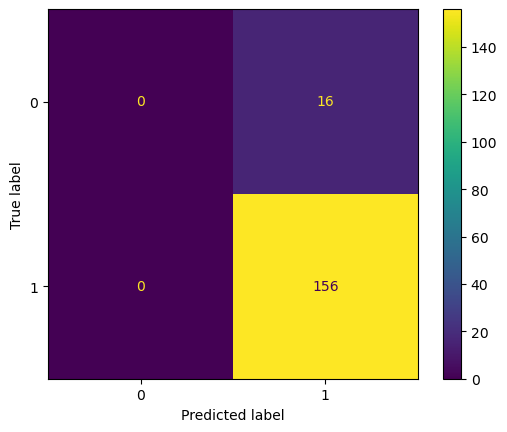

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


compound_col = "Metadata_Compound Name"
concentration_col = "Metadata_assay_conc_uM"
annotation_col = "Metadata_Annotation"
features = [col for col in norm_data.columns if not col.startswith("Metadata")]


norm_data["label"] = (norm_data[concentration_col] != 0).astype(int)

X = norm_data[features].values
y = norm_data["label"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)


y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();

probas = clf.predict_proba(X)[:, 1]
norm_data["proba_treated"] = probas

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, precision_recall_curve
import numpy as np
import pandas as pd

compound_col = "Metadata_Compound Name"
category = "Metadata_Annotation"
concentration_col = "Metadata_assay_conc_uM"
feat_data = norm_data.drop(columns=[col for col in norm_data.columns if col.startswith("Metadata")])
features = feat_data.columns
results = {}


df_dmso = norm_data[norm_data[concentration_col] == 0]
df_jump_control = norm_data[norm_data[category] == "JUMP control"]


df_dmso_filt = df_dmso.drop(columns=[col for col in df_dmso.columns if col.startswith("Metadata")])
df_jump_control_filt = df_jump_control.drop(columns=[col for col in df_jump_control.columns if col.startswith("Metadata")])

df_dmso_train= df_dmso_filt[10:64]

df_dmso_train["label"] = 0
df_jump_control_filt["label"] = 1


df_train = pd.concat([df_dmso_train, df_jump_control_filt])

X_train = df_train[features].values
y_train = df_train["label"].values


clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)


df_controls_pos = norm_data[norm_data[category] != "JUMP control"]
df_controls_pos = df_controls_pos[df_controls_pos[category] != "DMSO"]
#df_controls_neg = norm_data[norm_data[concentration_col] == 0].copy()

df_dmso_10 = df_dmso[0:10]

df_pred = pd.concat([df_controls_pos, df_dmso_10])

# Filtrer et préparer les données pour la prédiction
#df_controls_pos_filt = df_controls_pos.drop(columns=[col for col in df_controls_pos.columns if col.startswith("Metadata")])
#df_controls_neg_filt = df_controls_neg.drop(columns=[col for col in df_controls_neg.columns if col.startswith("Metadata")])
df_pred_filt= df_pred.drop(columns=[col for col in df_pred.columns if col.startswith("Metadata")])


X_pred = df_pred_filt[features].values


y_pred_proba = clf.predict_proba(X_pred)[:, 1]

df_pred['Probability'] = y_pred_proba

print(df_pred)


    Metadata_plate_map_name Metadata_source_plate  \
26               BR00145692                Plate1   
27               BR00145692                Plate1   
28               BR00145692                Plate1   
29               BR00145692                Plate1   
30               BR00145692                Plate1   
..                      ...                   ...   
71               BR00145692                Plate1   
73               BR00145692                Plate1   
95               BR00145692                Plate1   
97               BR00145692                Plate1   
119              BR00145692                Plate1   

    Metadata_source_well_position Metadata_destination_plate  \
26                            B03                      Dest1   
27                            B04                      Dest1   
28                            B05                      Dest1   
29                            B06                      Dest1   
30                            B07          

/var/folders/s6/prvmffjx7bl2mwcbcpxy05ph0000gn/T/ipykernel_7706/3793146753.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dmso_train["label"] = 0


In [ ]:
df_pred.to_csv("../outputs/df_pred.csv", index=False)

In [9]:

print(unique_compounds)

 [1] "Actinomycin D"                          
 [2] "Calcipotriol (hydrate)"                 
 [3] "Treprostinil"                           
 [4] "Cladribine"                             
 [5] "Cucurbitacin I"                         
 [6] "FCCP"                                   
 [7] "CLIOQUINOL"                             
 [8] "Bevirimat"                              
 [9] "IOPANOIC ACID"                          
[10] "Staurosporine"                          
[11] "Fluazinam"                              
[12] "MUPIROCIN"                              
[13] "Triamcinolone acetonide"                
[14] "Ethoxyquin"                             
[15] "Cycloheximide"                          
[16] "5,6-benzoflavone"                       
[17] "Rifampicin"                             
[18] "Colistin Methanesulfonate (sodium salt)"
[19] "Amperozide"                             
[20] "5,8,11-Eicosatriynoic acid"             
[21] "Nedocromil (sodium salt)"               
[22] "Berberi

In [11]:
library(ggplot2)
library(dplyr)
library(ggplot2)

df_pred <- read.csv("../outputs/df_pred.csv")

unique_compounds <- unique(df_pred$Metadata_Compound.Name)


n_per_page <- 9  
n_pages <- ceiling(length(unique_compounds) / n_per_page)

# Fichier de sortie PDF
pdf_file <- "../outputs/probability_curves_per_compound.pdf"
pdf(pdf_file, width = 15, height = 10)

for (i in 1:n_pages) {
  tryCatch({
    # Sous-ensemble des composés pour cette page
    compounds_subset <- unique_compounds[((i - 1) * n_per_page + 1):(i * n_per_page)]
    page_data <- df_pred[df_pred$Metadata_Compound.Name %in% compounds_subset, ]

    # Plot
    p <- ggplot(page_data, aes(x = Metadata_assay_conc_uM, y = Probability)) +
      geom_point(show.legend = FALSE, alpha = 0.6) +
      geom_smooth(method = "loess", span = 0.5, color = "darkred", se = FALSE) +
      facet_wrap(~ Metadata_Compound.Name, scales = "free_y") +
      labs(
        title = sprintf("Dose-Response Curves (Page %d)", i),
        x = "Concentration",
        y = "Predicted Probability"
      ) +
      theme_bw() +
      theme(strip.text = element_text(size = 9))

    print(p)

  }, error = function(e) {
    message(sprintf("Error on page %d : %s", i, e$message))
  })
}

dev.off()


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


pdf 
  2

## Model Based Clustering applied to well level CP data

In [ ]:

from scipy.stats import multivariate_normal


def initialize_parameters(X, K):
   np.random.seed(42)
   n_samples, n_features = X.shape
   mu = X[np.random.choice(n_samples, K, replace=False)]
   pi = np.ones(K) / K
   Sigma = np.array([np.eye(n_features) for _ in range(K)])

   return mu, Sigma, pi



#pour éviter les matrices singulières 
def regularize_covariance(cov, epsilon=1e-4):
    return cov + np.eye(cov.shape[0]) * epsilon
  

def e_step(X, mu, Sigma, pi):
    n_samples, n_features = X.shape
    K = len(pi)
    log_alpha = np.zeros((n_samples, K))
    
    for k in range(K):
        cov_matrix = regularize_covariance(Sigma[k])
        
        rv = multivariate_normal(mean=mu[k], cov=cov_matrix)
        
        log_pdf_values = rv.logpdf(X)
        
        log_alpha[:, k] = np.log(pi[k]) + log_pdf_values

    log_alpha_max = np.max(log_alpha, axis=1, keepdims=True)
    log_alpha -= log_alpha_max
    alpha = np.exp(log_alpha)
    
    alpha_sum = alpha.sum(axis=1)[:, np.newaxis]
    alpha_sum = np.maximum(alpha_sum, 1e-10)
    alpha /= alpha_sum

    if np.any(np.isnan(alpha)) or np.any(np.isinf(alpha)):
        raise ValueError("Alpha contains invalid values.")
    
    return alpha





def m_step(X, alpha):
    n_samples, n_features = X.shape
    K = alpha.shape[1]
    Nk = alpha.sum(axis=0)

    pi = Nk / n_samples
    pi = np.maximum(pi, 1e-10)
    pi /= np.sum(pi)

    mu = np.dot(alpha.T, X) / Nk[:, np.newaxis]

    Sigma = np.zeros((K, n_features, n_features))

    for k in range(K):
        diff = X - mu[k]
        poids = alpha[:, k][:, np.newaxis] * diff
        poids = np.dot(poids.T, diff)
        diag_covariance = np.diag(poids) / Nk[k]
        Sigma[k] = np.diag(diag_covariance)
        
        # Vérification de la matrice de covariance
        if np.any(np.isnan(Sigma[k])) or np.any(np.isinf(Sigma[k])):
            print(f"Invalid values in covariance matrix for cluster {k}")
    
    return mu, Sigma, pi


def log_likelihood(X, mu, Sigma, pi):
    n_samples = X.shape[0]
    n_clusters = len(pi)
    densities = []

    for k in range(n_clusters):
        try:
            densities.append(multivariate_normal.pdf(X, mean=mu[k], cov=Sigma[k]))
        except np.linalg.LinAlgError:
           
            Sigma[k] += np.eye(len(Sigma[k])) #* 1e-6  # Small regularization
            densities.append(multivariate_normal.pdf(X, mean=mu[k], cov=Sigma[k]))

    densities = np.array(densities).T
    weighted_densities = densities * pi
    ll = np.sum(np.log(np.sum(weighted_densities, axis=1) + 1e-10))

    return ll




def log_likelihood_complete(X, mu, Sigma, pi, alpha):
    log_densities = np.array([multivariate_normal.logpdf(X, mean=mu[k], cov=Sigma[k]) for k in range(len(pi))]).T
    weighted_log_densities = alpha * (np.log(pi) + log_densities)
    ll_comp = np.sum(weighted_log_densities)
    return ll_comp





## EM sans les critères
def em_algorithm(X, K, max_iter=100, tol=1e-4):
    mu, Sigma, pi = initialize_parameters(X, K)
    log_likelihoods = []

    for iteration in range(max_iter):
        alpha = e_step(X, mu, Sigma, pi)
        mu, Sigma, pi = m_step(X, alpha)
        ll = log_likelihood_complete(X, mu, Sigma, pi, alpha)  
        log_likelihoods.append(ll)


        if iteration > 0 and abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
            break

    return mu, Sigma, pi, alpha



np.random.seed(42)



In [ ]:


def find_best_initialization(X_ref, K, n_init=10, max_iter=100, tol=1e-6):
    best_ll_complete = -np.inf
    best_params = None
    for init in range(n_init):
        try:
            mu, Sigma, pi = initialize_parameters(X_ref, K)
            mu_est, Sigma_est, pi_est, alpha_est = em_algorithm(
                X_ref, K, max_iter=max_iter, tol=tol
            )
            ll_complete = log_likelihood_complete(X_ref, mu_est, Sigma_est, pi_est, alpha_est)
            if ll_complete > best_ll_complete:
                best_ll_complete = ll_complete
                best_params = {"mu": mu_est, "Sigma": Sigma_est, "pi": pi_est}
        except Exception as e:
            print(f"Initialization {init + 1}/{n_init} failed: {e}")
    if best_params is None:
        raise ValueError("No valid initialization was found.")
    return best_params





def compute_bic(X, num_param, log_likelihood):
    n_samples = X.shape[0]
    return (-2) * log_likelihood + np.log(n_samples) * num_param

def compute_aic(log_likelihood, num_param):
    return -2 * log_likelihood + 2 * num_param



def compute_icl(X, num_param, log_likelihood_comp):
    n_samples = X.shape[0]
    return (-2) * log_likelihood_comp + np.log(n_samples) * num_param



# Algorithme EM avec calcule des critères 
def em_algorithm_crit(X, K, n_well, max_iter=100, tol=1e-6):
    try:
        best_params = find_best_initialization(X, K)
    except ValueError as e:
        print(e)
        return None, None, None, None
    
    mu, Sigma, pi = best_params["mu"], best_params["Sigma"], best_params["pi"]
    n_samples, n_features = X.shape
    log_likelihoods = []

    for iteration in range(max_iter):
        alpha = e_step(X, mu, Sigma, pi)  
        mu, Sigma, pi = m_step(X, alpha)  
        
        ll = log_likelihood(X, mu, Sigma, pi)  # Log-vraisemblance simple
        ll_comp = log_likelihood_complete(X, mu, Sigma, pi, alpha) # Log-vraisemblance complète
        
        log_likelihoods.append(ll)
        
        if iteration > 0 and abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
            break

    # Calcul des critères
    num_param = 2*K * n_features + (K-1)*n_well
    icl = compute_icl(X, num_param, ll_comp)

    print(f"K={K}, Log-likelihood={ll:.2f}, Log-likelihood Complete={ll_comp:.2f}, Num Params={num_param}, ICL={icl:.2f}")

    return mu, Sigma, pi, alpha, icl



n_well= norm_data['Metadata_Well'].nunique()

K_values = range(2, 7)
icl_scores = []


for K in K_values:
    _, _, _, _, icl = em_algorithm_crit(scaled, K, n_well)
    icl_scores.append(icl)


optimal_K_icl = K_values[np.argmin(icl_scores)]

print(f"Optimal K based on ICL: {optimal_K_icl}")



In [ ]:
## optimal number of clusters K= 6 but I did 4 bc we see much better the separation of the clusters

mu, Sigma, pi, alpha = em_algorithm(scaled,4)
print("Means:", mu)
print("Covariances:", Sigma)
print("Proportions:", pi)

Means: [[ 0.35646338 -0.27027968  0.50717175 ... -0.44154172  0.50421772
   0.02269905]
 [-0.50544962  0.18729155 -0.28993879 ...  0.23530269 -0.30510769
  -0.06699984]
 [ 0.30780729  0.28222394 -0.7933641  ... -0.07856226  0.74672302
   0.42902729]
 [ 0.25920331 -0.20903722  0.46304318 ...  0.12995478 -0.51887602
  -0.19420224]]
Covariances: [[[0.45204458 0.         0.         ... 0.         0.         0.        ]
  [0.         0.81087432 0.         ... 0.         0.         0.        ]
  [0.         0.         0.4573777  ... 0.         0.         0.        ]
  ...
  [0.         0.         0.         ... 0.71078879 0.         0.        ]
  [0.         0.         0.         ... 0.         0.40238939 0.        ]
  [0.         0.         0.         ... 0.         0.         0.10556194]]

 [[0.37616478 0.         0.         ... 0.         0.         0.        ]
  [0.         0.99274856 0.         ... 0.         0.         0.        ]
  [0.         0.         0.35657819 ... 0.         0.  

In [ ]:
cluster_assignments = np.argmax(alpha, axis=1)

df = pd.DataFrame({
    'Cluster': cluster_assignments,
    'Name': norm_data['Metadata_Compound Name'],
    'Well' : norm_data['Metadata_Well'],
    'Plate' : norm_data['Metadata_Plate'],
    'Concentration': norm_data['Metadata_assay_conc_uM'],
    'Category': norm_data['Metadata_Annotation']
})

cluster_freq = df.groupby(['Well', 'Concentration', 'Name', 'Plate'])['Cluster'].value_counts(normalize=True).unstack(fill_value=0)


Do a graph of each cluster showing the names and the concentration of compound in that cluster  x per plate

In [ ]:
print(df)

     Cluster         Name Well       Plate  Concentration      Category
0          3      AMG 900  E03  BR00145692            5.1  JUMP control
1          3         DMSO  A17  BR00145692            0.0          DMSO
22         1      AMG 900  F22  BR00145692            5.1  JUMP control
23         0         DMSO  A20  BR00145692            0.0          DMSO
24         0      AMG 900  G15  BR00145692            5.1  JUMP control
..       ...          ...  ...         ...            ...           ...
743        3         DMSO  P01  BR00145695            0.0          DMSO
744        0  Aloxistatin  F17  BR00145695            5.1  JUMP control
745        0         DMSO  H07  BR00145695            0.0          DMSO
766        3  Aloxistatin  N24  BR00145695            5.1  JUMP control
767        3         DMSO  P16  BR00145695            0.0          DMSO

[688 rows x 6 columns]


In [ ]:
summary

Category,DMSO,JUMP control,negative control,positive control,total,pct_DMSO,pct_JC,pct_PC,pct_NC
Cluster,,,,,,,,,
0,27,25,61,54,167,0.161677,0.149701,0.323353,0.365269
1,21,35,88,117,261,0.080460,0.134100,0.448276,0.337165
2,2,3,21,77,103,0.019417,0.029126,0.747573,0.203883
3,14,21,50,72,157,0.089172,0.133758,0.458599,0.318471


In [ ]:
tableau = df[['Cluster', 'Name', 'Concentration', 'Category', 'Plate']].sort_values(by='Cluster')
print(tableau)

     Cluster                       Name  Concentration Category       Plate
383        0                       DMSO        0.00000     DMSO  BR00145692
265        0                       DMSO        0.00000     DMSO  BR00145692
266        0   Nedocromil (sodium salt)       75.00000       NC  BR00145692
269        0   Nedocromil (sodium salt)        2.77780       NC  BR00145692
270        0   Nedocromil (sodium salt)        0.92593       NC  BR00145692
..       ...                        ...            ...      ...         ...
495        3                  Bevirimat       11.11100       NC  BR00145695
496        3                  Bevirimat        3.70370       NC  BR00145695
497        3                  Bevirimat        1.23460       NC  BR00145695
305        3  Aminodarone Hydrochloride        0.15432       PC  BR00145692
767        3                       DMSO        0.00000     DMSO  BR00145695

[688 rows x 5 columns]


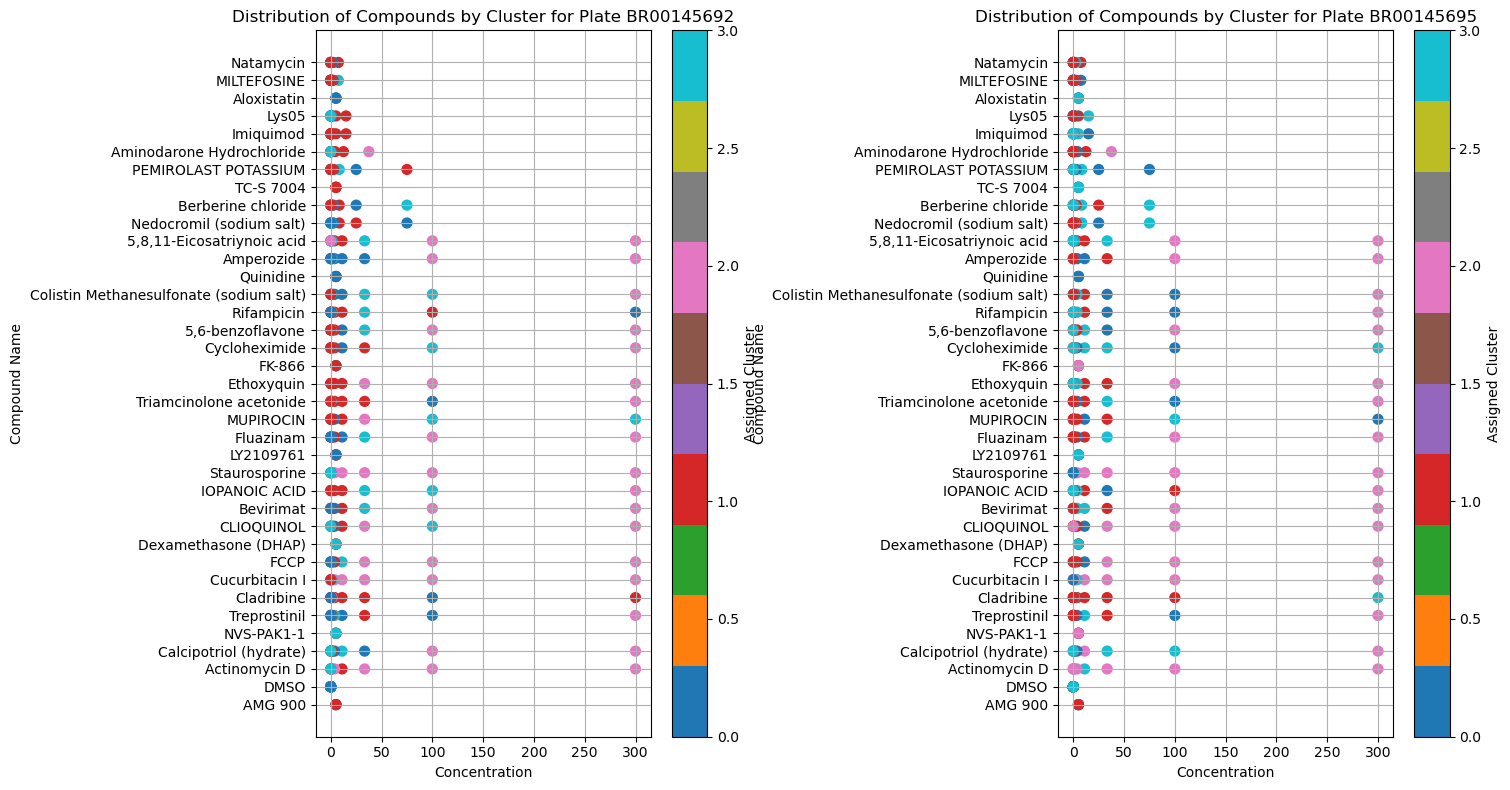

In [ ]:
## plot the distribution of the clusters per plate

fig, ax = plt.subplots(1, 2, figsize=(15, 8))

plates = df['Plate'].unique()

for i, plate in enumerate(plates):
    df_plate = df[df['Plate'] == plate]
    scatter = ax[i].scatter(df_plate['Concentration'], df_plate['Name'], 
                             c=df_plate['Cluster'], cmap='tab10', s=50)
    ax[i].set_xlabel("Concentration")
    ax[i].set_ylabel("Compound Name")
    ax[i].set_title(f"Distribution of Compounds by Cluster for Plate {plate}")
    ax[i].grid(True)
    fig.colorbar(scatter, ax=ax[i], label="Assigned Cluster")

plt.tight_layout()
plt.show()


We calculate the number of DMSO wells for each cluster and plate. They are mostly found in clusters 1 and 2. In the heatmap results, we can clearly observe that for the first plate, clusters 1, 2, and 4 consist of DMSO wells + compounds at concentrations up to 100 µM, except for Mupirocin, which is at 200 µM. For cluster 2, the majority are compounds at high concentrations (starting from 75 µM), positive controls known to induce a phenotypic effect in HepaRG cells and negative controls where we could say the effects are more evident at higher concentrations. For the second plate, the same trends apply with the majority of DMSO wells in clusters 1 and 2. The trends for the other compounds are also similar.

In [ ]:
# number of wells DMSO per cluster and per plate
dmso_df = tableau[tableau['Name'] == 'DMSO']

dmso_count = dmso_df.groupby(['Cluster', 'Plate', 'Concentration']).size().reset_index(name='DMSO Count')

print(dmso_count)


   Cluster       Plate  Concentration  DMSO Count
0        0  BR00145692            0.0          15
1        0  BR00145695            0.0          12
2        1  BR00145692            0.0           8
3        1  BR00145695            0.0          13
4        2  BR00145695            0.0           2
5        3  BR00145692            0.0           9
6        3  BR00145695            0.0           5


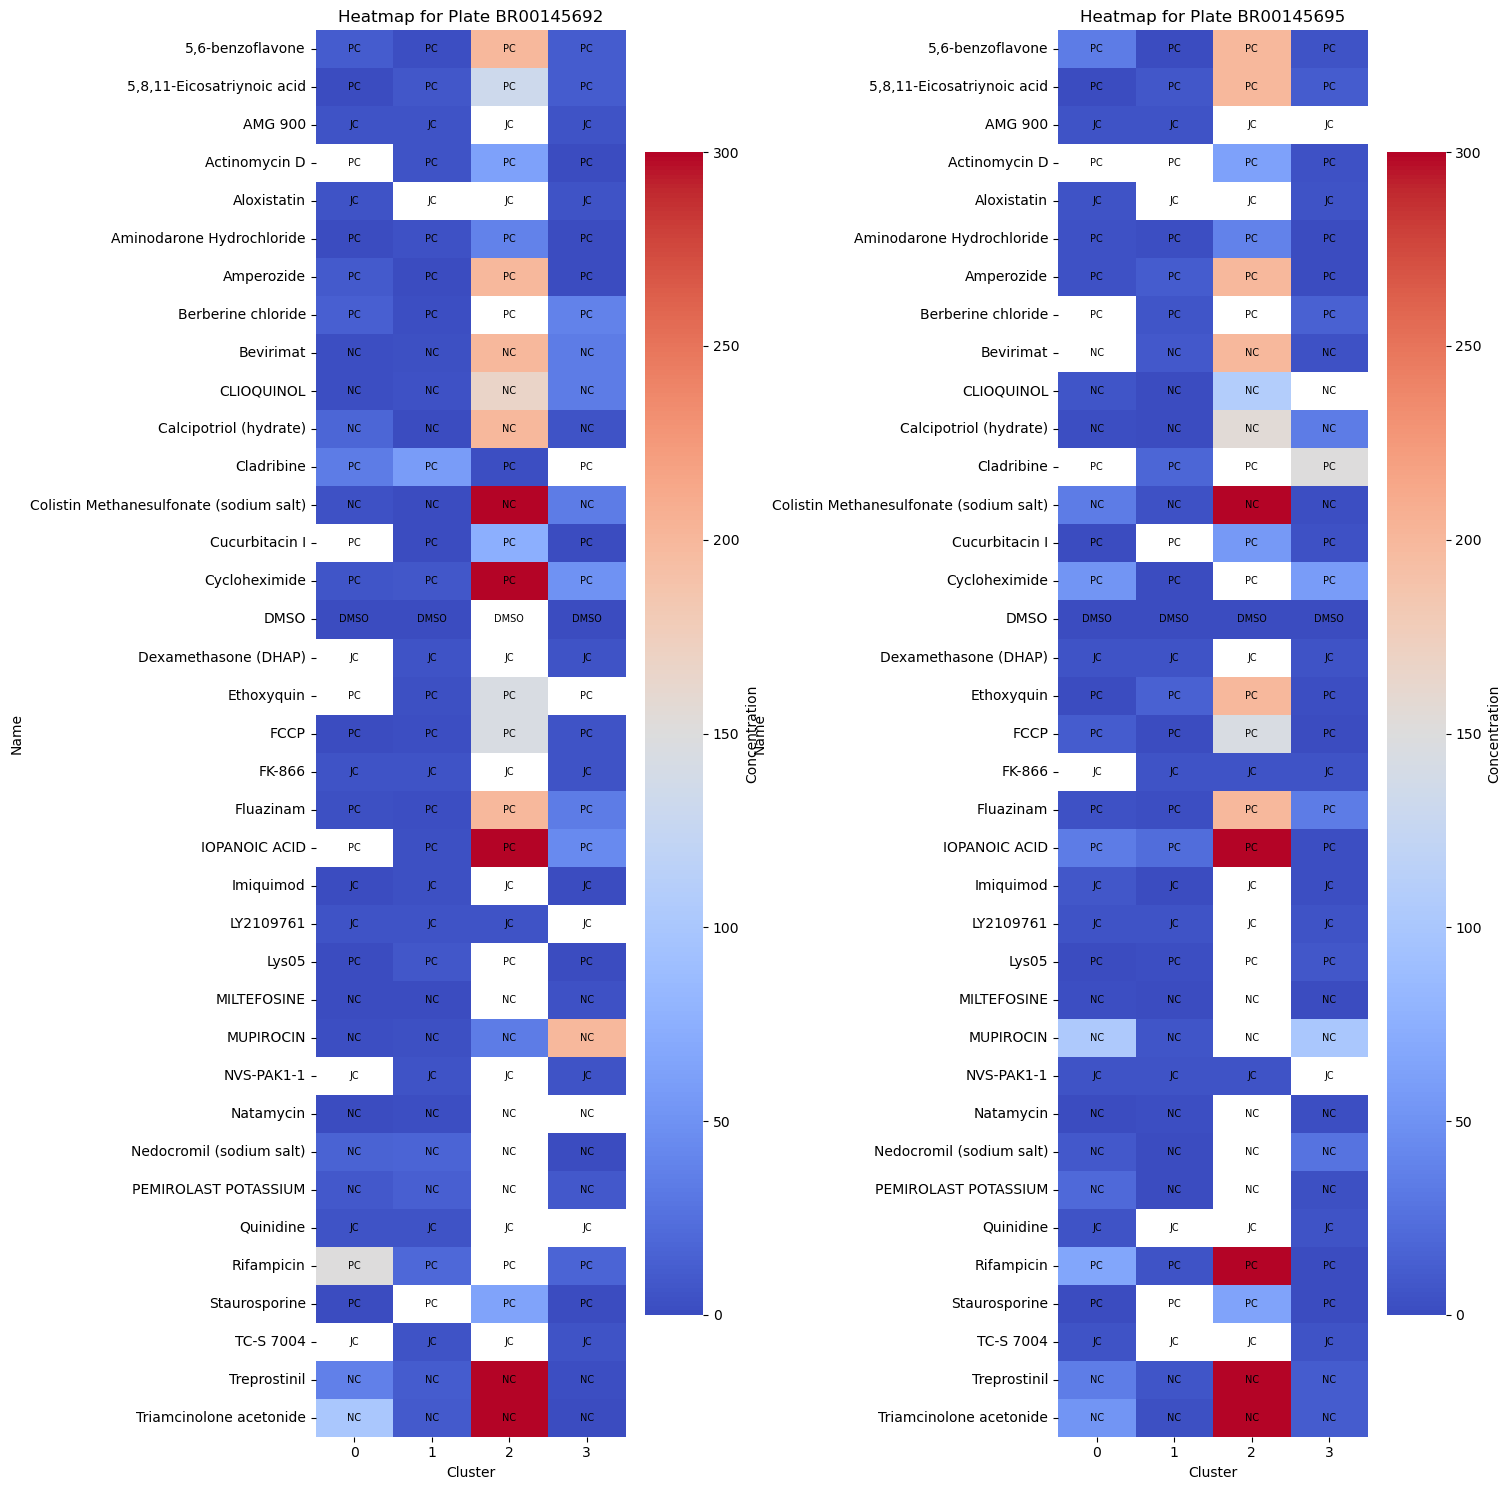

In [ ]:
## heatmap of the clusters per plate

plates = df['Plate'].unique()

df['Category'] = df['Category'].replace({'positive control': 'PC', 'negative control': 'NC', 'JUMP control': 'JC'})

fig, ax = plt.subplots(1, len(plates), figsize=(15,15))

for i, plate in enumerate(plates):
    df_plate = df[df['Plate'] == plate]
    heatmap_data = df_plate.pivot_table(index='Name', columns='Cluster', values='Concentration')
    categories = df_plate.groupby('Name')['Category'].first()

    ax[i].set_title(f"Heatmap for Plate {plate}")
    sns.heatmap(heatmap_data, cmap='coolwarm', cbar_kws={'label': 'Concentration'}, annot=False, ax=ax[i])

    for j in range(len(heatmap_data.index)):
        for k in range(len(heatmap_data.columns)):
            ax[i].text(k + 0.5, j + 0.5, categories[heatmap_data.index[j]], ha='center', va='center', color='black', fontsize=7)

    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=0)
    ax[i].set_yticklabels(ax[i].get_yticklabels(), rotation=0)

plt.tight_layout()
plt.show()



We analyze the distribution of wells across clusters by compound category (DMSO, positive control, etc.). Clusters enriched in positive controls are annotated as 'phenotype-altered'. Then, for each tested compound, the POD was defined as the lowest concentration at which its wells were assigned predominantly to an altered cluster. We extract the first concentration for each compound where more than 50% of its wells are assigned to the "altered" cluster.

In [ ]:
## POD determination 

summary = df.groupby(['Cluster', 'Category']).size().unstack(fill_value=0)
summary['total'] = summary.sum(axis=1)
summary['pct_DMSO'] = summary.get('DMSO', 0) / summary['total']
summary['pct_JC'] = summary.get('JUMP control', 0) / summary['total']
summary['pct_PC'] = summary.get('positive control', 0) / summary['total']
summary['pct_NC'] = summary.get('negative control', 0) / summary['total']


altered_clusters = summary[summary['pct_PC'] > 0.5].index.tolist()

df['is_altered'] = df['Cluster'].isin(altered_clusters)

grouped = df.groupby(['Name', 'Concentration', 'Plate', 'Category'])
pod_data = grouped['is_altered'].mean().reset_index(name='pct_altered')

threshold = 0.5

pod = (
    pod_data[pod_data['pct_altered'] > threshold]
    .sort_values(by=['Name', 'Concentration', 'Category'])
    .groupby('Name')
    .first()
    .reset_index()[['Name', 'Concentration', 'Category']]
    .rename(columns={'Concentration': 'POD'})
)


print("Altered Clusters:", altered_clusters)
print(pod)


Altered Clusters: [2]
                                       Name        POD          Category
0                          5,6-benzoflavone  100.00000  positive control
1                5,8,11-Eicosatriynoic acid    0.01520  positive control
2                             Actinomycin D    0.01520  positive control
3                 Aminodarone Hydrochloride   37.50000  positive control
4                                Amperozide  100.00000  positive control
5                                 Bevirimat  100.00000  negative control
6                                CLIOQUINOL    0.01520  negative control
7                    Calcipotriol (hydrate)   11.11100  negative control
8                                Cladribine    1.23460  positive control
9   Colistin Methanesulfonate (sodium salt)  300.00000  negative control
10                           Cucurbitacin I    0.04570  positive control
11                            Cycloheximide  300.00000  positive control
12                           

In [ ]:
altered_clusters = summary[summary['pct_DMSO'] > 0.1].index.tolist()

df['is_altered'] = df['Cluster'].isin(altered_clusters)

grouped = df.groupby(['Name', 'Concentration', 'Plate', 'Category'])
pod_data = grouped['is_altered'].mean().reset_index(name='pct_altered')

threshold = 0.5
pod = (
    pod_data[pod_data['pct_altered'] > threshold]
    .sort_values(by=['Name', 'Concentration', 'Category'])
    .groupby('Name')
    .first()
    .reset_index()[['Name', 'Concentration', 'Category']]
    .rename(columns={'Concentration': 'POD'})
)


print("Altered Clusters:", altered_clusters)
print(pod)

Altered Clusters: [0]
                                       Name       POD          Category
0                          5,6-benzoflavone  11.11100  positive control
1                5,8,11-Eicosatriynoic acid   0.04570  positive control
2                               Aloxistatin   5.10000      JUMP control
3                 Aminodarone Hydrochloride   0.05140  positive control
4                                Amperozide   0.01520  positive control
5                        Berberine chloride   2.77780  positive control
6                                 Bevirimat   0.01520  negative control
7                                CLIOQUINOL   0.13717  negative control
8                    Calcipotriol (hydrate)   0.04570  negative control
9                                Cladribine   0.01520  positive control
10  Colistin Methanesulfonate (sodium salt)   0.04570  negative control
11                           Cucurbitacin I   0.01520  positive control
12                            Cycloheximid